# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [32]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sivar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [34]:
data = pd.read_csv('preprocessed_data.csv')

In [35]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [36]:
negative = []
positive = []
neutral = []
compound = []

def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

In [37]:
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [08:02<00:00, 226.53it/s]


In [38]:
data["neg"] = negative
data["pos"] = positive
data["neu"] = neutral        
data["compound"] = compound

In [39]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [40]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y=data["project_is_approved"].values
X=data.drop(["project_is_approved"],axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)
print("Total data points in Train Dataset =",len(y_train))
print("Total data points in Test Dataset =",len(y_test))

Total data points in Train Dataset = 73196
Total data points in Test Dataset = 36052


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### Make Data Model Ready: Encoding Eassay(text feature)

#### TFIDF Vectorizer

In [41]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
tfidfvectorizer=TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf=tfidfvectorizer.fit(X_train["essay"].values)

print("Before vectorizations")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("*"*50)

X_train_essay_tfidf=tfidfvectorizer.transform(X_train["essay"].values)
X_test_essay_tfidf=tfidfvectorizer.transform(X_test["essay"].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

Before vectorizations
(73196, 12) (73196,)
(36052, 12) (36052,)
**************************************************
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


### TFIDF W2V

In [42]:
import pickle
with open(r'glove_vectors',"rb") as f:
    model=pickle.load(f)
    glove_words=set(model.keys())

In [43]:
tfidf_model=TfidfVectorizer()
tfidf_model.fit(X_train["essay"])
dictionary=dict(zip(tfidf_model.get_feature_names(),list(tfidf_model.idf_)))
tfidf_words=set(tfidf_model.get_feature_names())

### TFIDF W2V FOR TRAIN DATASET

In [62]:
train_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_train['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)
X_train_essay_tfidf_w2v= sparse.csr_matrix(train_tfidf_w2v_essays)
print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, y_train.shape)

100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [05:54<00:00, 206.42it/s]


After vectorizations
(73196, 300) (73196,)


### TFIDF W2V FOR TEST DATASET

In [63]:
test_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_test['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)
X_test_essay_tfidf_w2v= sparse.csr_matrix(test_tfidf_w2v_essays)
print("After vectorizations")
print(X_test_essay_tfidf_w2v.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [02:56<00:00, 204.84it/s]


After vectorizations
(36052, 300) (36052,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [46]:
def fit(feature):
    X_train['class_label']=y_train # adding 'project_is_approved' column to x_train
    count = X_train[ feature ].value_counts() # getting value counts(denominator) of each category
    feature_dictionary = dict()
    for i, denominator in count.items():
        vector = []
        for j in range(2):
            compare =X_train.loc[ ( X_train['class_label'] == j ) & (X_train[feature] == i ) ]
            vector.append( len( compare)  / denominator   )
        feature_dictionary[i] = vector    # adding probability of each class label for a pariticular category of feature
    return feature_dictionary  
def transform(feature, df ):
    feature_dictionary = fit(feature)
    count = X_train[feature].value_counts()
    f=[]
    for cat in df[feature]:
        if cat in dict( count ).keys():# transform test data with trainning probabilities
            f.append( feature_dictionary[cat] )
        else:
            f.append([0.5, 0.05])
    return f

### ENCODING CATEGORICAL FEATURES: SCHOOL STATE

In [47]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

X_train_state_rc =np.array(transform('school_state',X_train))
X_test_state_rc =np.array(transform('school_state',X_test)) 
print("After vectorizations")
print(X_train_state_rc.shape, y_train.shape)
print(X_test_state_rc.shape, y_test.shape)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#### ENCODING CATEGORICAL FEATURES: TEACHER_PREFIX

In [48]:
X_train_teacher_rc =np.array(transform('teacher_prefix',X_train))
X_test_teacher_rc = np.array(transform('teacher_prefix',X_test))
print("After vectorizations")
print(X_train_teacher_rc.shape, y_train.shape)
print(X_test_teacher_rc.shape, y_test.shape)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#### Encoding Categorical Features: project_grade_category

In [49]:
X_train_grade_rc = np.array(transform('project_grade_category',X_train))
X_test_grade_rc = np.array(transform('project_grade_category',X_test))

print("After vectorizations")
print(X_train_grade_rc.shape, y_train.shape)
print(X_test_grade_rc.shape, y_test.shape)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#### Encoding Categorical Features: clean_categories

In [50]:
X_train_category_rc =np.array(transform('clean_categories',X_train))
X_test_category_rc = np.array(transform('clean_categories',X_test))

print("After vectorizations")
print(X_train_category_rc.shape, y_train.shape)
print(X_test_category_rc.shape, y_test.shape)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


#### Encoding Categorical Features: clean_subcategories

In [51]:
X_train_subcategory_rc =np.array(transform('clean_subcategories',X_train))
X_test_subcategory_rc = np.array(transform('clean_subcategories',X_test))

print("After vectorizations")
print(X_train_subcategory_rc.shape, y_train.shape)
print(X_test_subcategory_rc.shape, y_test.shape)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


### Encoding Numerical Features

#### Encoding Numerical Feature :price

In [52]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1)) #fitting

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))  #transform
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm =X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#### Encoding Numerical Features:teacher_number_of_previously_posted_projects

In [53]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) #fitting
X_train_submission_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))  
X_test_submission_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm =X_train_submission_norm .reshape(-1,1)
X_test_submission_norm=X_test_submission_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_submission_norm.shape, y_train.shape)
print(X_test_submission_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#### Encoding Numerical Features:neg

In [54]:
normalizer=Normalizer()
normalizer.fit(X_train["neg"].values.reshape(1,-1))

X_train_neg_norm=normalizer.transform(X_train["neg"].values.reshape(1,-1))
X_test_neg_norm=normalizer.transform(X_test["neg"].values.reshape(1,-1))

X_train_neg_norm=X_train_neg_norm.reshape(-1,1)
X_test_neg_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorization")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)

After vectorization
(73196, 1) (73196,)
(36052, 1) (36052,)


#### Encoding Numerical Features:pos

In [55]:
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(1,-1)) #fitting

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))  #transform
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

X_train_pos_norm =X_train_pos_norm .reshape(-1,1)
X_test_pos_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#### Encoding Numerical Features:neu

In [56]:
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(1,-1)) #fitting
X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

X_train_neu_norm =X_train_neu_norm .reshape(-1,1)
X_test_neu_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#### Encoding Numerical Features:compound

In [57]:
normalizer.fit(X_train['compound'].values.reshape(1,-1)) #fitting

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))  #transform
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

X_train_compound_norm =X_train_compound_norm .reshape(-1,1)
X_test_compound_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_compound_norm.shape, y_train.shape)
print(X_test_compound_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


## Concatinating All The Features

#### SET-1

#### Set 1: categorical, numerical features + preprocessed_eassay (TFIDF)

In [58]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_essay_tfidf, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm,X_train_neg_norm ,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set_one = hstack((X_test_essay_tfidf, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm,X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()

In [59]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 5016)
(36052, 5016)


#### SET-2

#### Set 2: categorical, numerical features + preprocessed_eassay (TFIDF W2V)

In [64]:
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_essay_tfidf_w2v, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm)).tocsr()
X_te_set_two = hstack((X_test_essay_tfidf_w2v, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm)).tocsr()

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

### GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 1)

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [66]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [67]:
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }

In [68]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4], 'n_estimators': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [69]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [70]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.6848760099663571
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


#### Plotting Hyperparameter v/s Auc

#### Roc Plot Of Train And Test Data

#### Train data

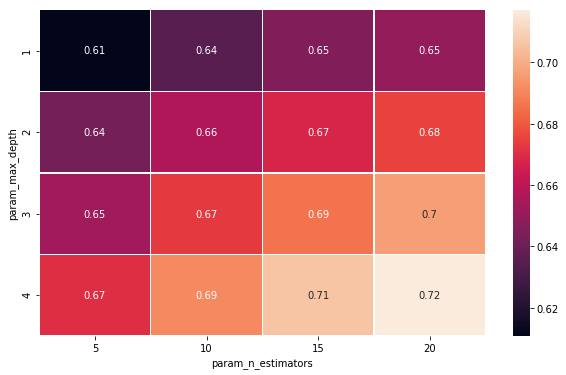

In [71]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

#### Test data

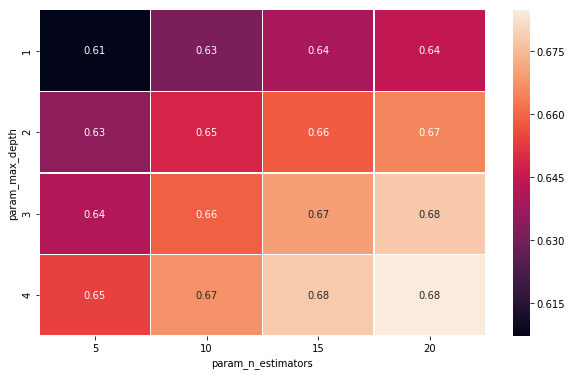

In [73]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

#### Roc Plot Of Train And Test Data

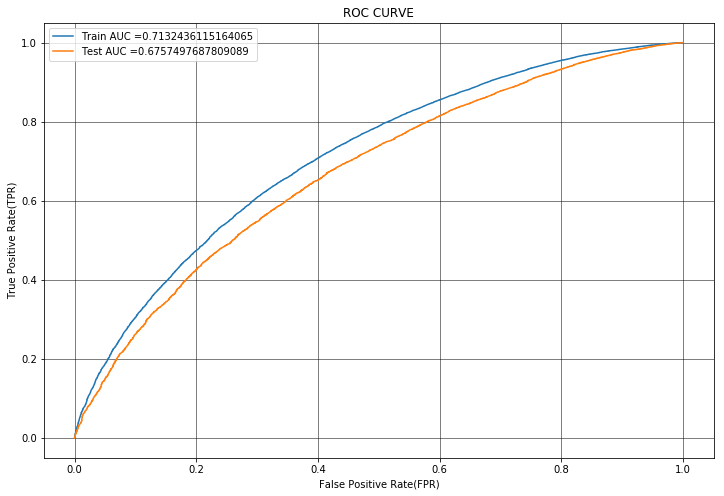

In [74]:
model_set1=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set1.fit(X_tr_set_one,y_train)
y_train_probs = clf.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

## Confusion Matrix

In [75]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Train Data

the maximum value of tpr*(1-fpr) 0.429765310356723 for threshold 0.849
CONFUSION MATRIX OF TRAIN DATA


[[ 7329  3754]
 [21746 40367]]


Text(0.5,1,'Train Data Confusion Matrix')

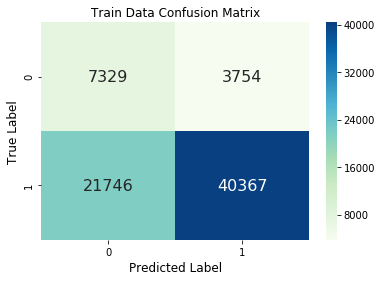

In [76]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

### Test Data

the maximum value of tpr*(1-fpr) 0.3939505070521307 for threshold 0.844
CONFUSION MATRIX OF TEST DATA


[[ 3353  2106]
 [10971 19622]]


Text(0.5,1,'Test Data Confusion Matrix')

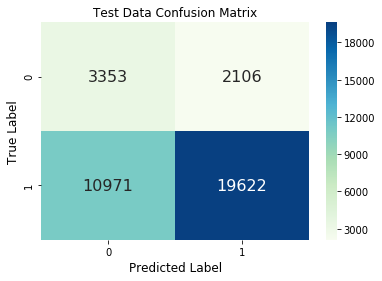

In [77]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

## GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 2)

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [80]:
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }

In [82]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4], 'n_estimators': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [83]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [84]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.6845554498149107
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


### Plotting Hyperparameter v/s Auc

### Train Data

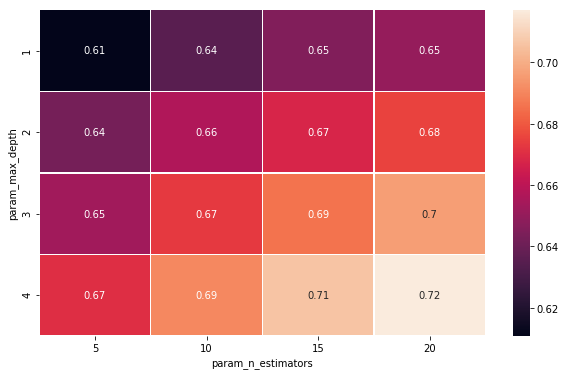

In [85]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') 
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

### Cross Validation data

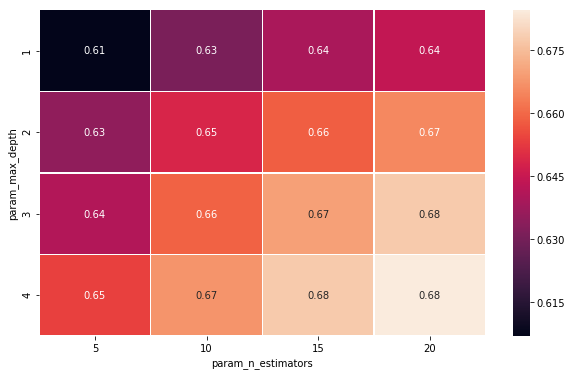

In [86]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

### Roc Plot Of Train And Test Data

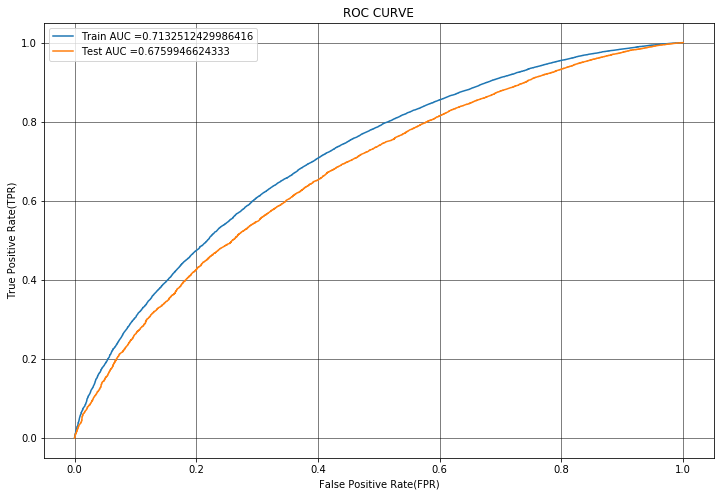

In [87]:
model_set2=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set2.fit(X_tr_set_one,y_train)
y_train_probs = model_set2.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= model_set2.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

### Confusion Matrix

In [88]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Train Data

the maximum value of tpr*(1-fpr) 0.42971731634481375 for threshold 0.849
CONFUSION MATRIX OF TRAIN DATA


[[ 7328  3755]
 [21745 40368]]


Text(0.5,1,'Train Data Confusion Matrix')

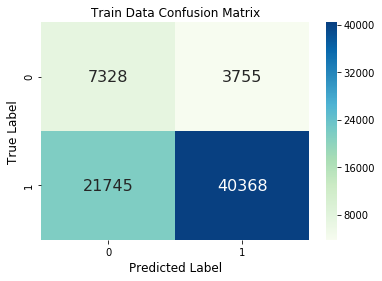

In [89]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

### Test Data

the maximum value of tpr*(1-fpr) 0.3941684138419743 for threshold 0.844
CONFUSION MATRIX OF TEST DATA


[[ 3354  2105]
 [10966 19627]]


Text(0.5,1,'Test Data Confusion Matrix')

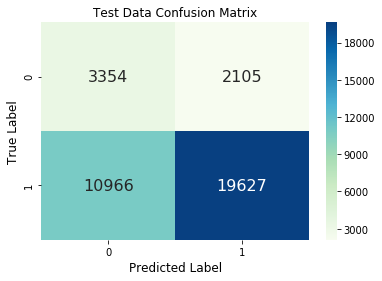

In [90]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)




















<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [91]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"]
table.add_row([1,"TFIDF", "GRADIENT BOOSTING CLASSIFIER", "max_depth =4 , n_estimators=20", 0.67515])
table.add_row([2,"TFIDF W2V", "GRADIENT BOOSTING CLASSIFIER"," max_depth =4 , n_estimators=20", 0.67517])
print(table)

+-------+------------+------------------------------+---------------------------------+----------+
| Sl.N0 | Vectorizer |            Model             |         Hyper Parameter         | Test-AUC |
+-------+------------+------------------------------+---------------------------------+----------+
|   1   |   TFIDF    | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67515  |
+-------+------------+------------------------------+---------------------------------+----------+
|   2   | TFIDF W2V  | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67517  |
+-------+------------+------------------------------+---------------------------------+----------+
